In [1]:
from jin_utils import get_mypkg_path
import sys
mypkg = get_mypkg_path()
sys.path.append(mypkg)

from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, SGM_prior_bds, MIDRES_ROOT

In [2]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time

plt.style.use(FIG_ROOT/"base.mplstyle")
%matplotlib inline

In [4]:
from utils.reparam import ThetaTransform
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from models.mlp import SGMnet
from models.model_utils import MyDataset
from joblib import Parallel, delayed

In [5]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [6]:
# load the dataset to get the freqs in real data (Apr 2, 2023)
import netCDF4
fils = list(DATA_ROOT.glob("*s100tp.nc"))
file2read = netCDF4.Dataset(fils[0], 'r')
psd_all = np.array(file2read.variables["__xarray_dataarray_variable__"][:])
time_points = np.array(file2read.variables["timepoints"][:])
freqs = np.array(file2read.variables["frequencies"][:])
ROIs_order = np.array(file2read.variables["regionx"][:])
file2read.close()

In [44]:
# some constant parameters for this file
paras = edict()

# alpha, gei, gii, taue, tauG, taui, speed 
names = ["alpha", "gei", "gii", "taue", "taug", "taui", "speed"]
# the mask to indicate which parameters are free to be optimized or not, if 0 use the default value
# order is alpha, gei, gii, taue, tauG, taui, speed (paras.names)
paras.params_mask = np.array([0, 0, 0, 1, 0, 0, 0], dtype=bool)
paras.names = [name for mask, name in zip(paras.params_mask, names) if mask]
paras.prior_bds = np.array([SGM_prior_bds[key] for key in paras.names])

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

sgmmodel = SGM(paras.C, paras.D, paras.freqs)

2025-02-28 11:18:47,477 - sgm.sgm - INFO - Num of ROI is 86.


In [45]:
# running parameters
# May change

paras_run = edict()

paras_run.n = 1000
paras_run.k = 0.15 # the parameter for reparameterization in logistic
paras_run.sd = 10 # The std to generate SGM parameters in raw scale (R)

theta_trans_fn = ThetaTransform(prior_bds=paras.prior_bds, k=paras_run.k)

In [46]:
# the function to generate PSD with SGM
def get_psd(cur_sgm):
    input_sgm = {}
    for ix, key in enumerate(paras.names):
        input_sgm[key] = cur_sgm[ix]
    cur_PSD = sgmmodel.forward_psd(input_sgm)
    cur_PSD = cur_PSD[:68, :]
    return cur_PSD

def get_fc(cur_sgm):
    input_sgm = {}
    for ix, key in enumerate(paras.names):
        input_sgm[key] = cur_sgm[ix]
    cur_PSD = sgmmodel.forward_fc(input_sgm)
    cur_PSD = cur_PSD[:68, :68]
    return cur_PSD

def _get_fc(sgm_params):
    """Get FC from sgm parameters based on sgmmodel
    args: 
        sgm_params: np.array, the sgm parameters 7
    return:
        fc: np.array, the fc after standardization, only the upper triangle with minmax normalization
    """
    fc = get_fc(sgm_params)
    fc_vec = fc[np.triu_indices(fc.shape[0], k=1)]
    fc_vec_std = (fc_vec-fc_vec.min())/(fc_vec.max()-fc_vec.min())
    return fc_vec_std

def _get_psd(sgm_params):
    """get psd from sgm parameters based on sgmmodel
    args: 
        sgm_params: np.array, the sgm parameters 7 
    return:
        psd: np.array, the psd in dB and after standardization
    """
    psd = get_psd(sgm_params)
    psd_db = 20*np.log10(psd)
    psd_db_std = (psd_db-psd_db.mean(axis=-1, keepdims=True))/psd_db.std(axis=-1, keepdims=True)
    return psd_db_std

## Grid search

In [47]:
sgm_paramss_raw_grid = np.linspace(-10, 10, 100).reshape(-1, 1);
sgm_paramss_grid = theta_trans_fn.raw2theta(sgm_paramss_raw_grid);
n_jobs = 5
with Parallel(n_jobs=n_jobs) as parallel:
    PSDs_grid = parallel(delayed(_get_psd)(cur_sgm) for cur_sgm in tqdm(sgm_paramss_grid))
    FCs_grid = parallel(delayed(_get_fc)(cur_sgm) for cur_sgm in tqdm(sgm_paramss_grid))
PSDs_grid = np.array(PSDs_grid);
FCs_grid = np.array(FCs_grid);

  0%|                                                                                                                                                                             | 0/100 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.32it/s]


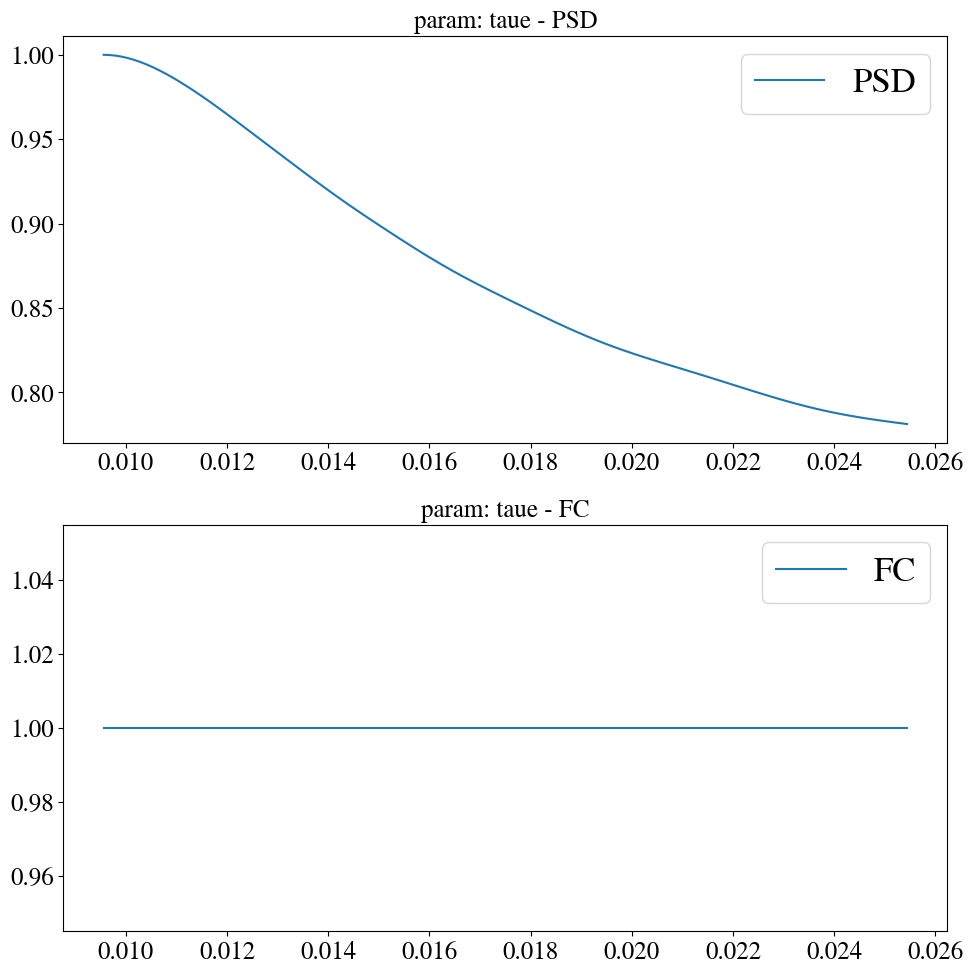

In [48]:
from models.loss import reg_R_fn

PSD_base = PSDs_grid[0]
PSDs_base = np.repeat(PSD_base[None], len(PSDs_grid), axis=0)

FC_base = FCs_grid[0]
FCs_base = np.repeat(FC_base[None], len(FCs_grid), axis=0)

corrs = reg_R_fn(PSDs_base, PSDs_grid)
mcorrs = corrs.mean(axis=-1)

mcorrs_fc = reg_R_fn(FCs_base, FCs_grid)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].set_title(f"param: {paras.names[0]} - PSD")
axs[0].plot(sgm_paramss_grid.reshape(-1), mcorrs, label="PSD")
axs[0].legend()

axs[1].set_title(f"param: {paras.names[0]} - FC")
axs[1].plot(sgm_paramss_grid.reshape(-1), mcorrs_fc, label="FC")
axs[1].legend()

plt.tight_layout()
plt.show()

## Try SGM 

In [142]:
from models.loss import reg_R_fn
import pandas as pd 
from functools import partial
from scipy.optimize import dual_annealing

In [ ]:
np.random.seed(0)
nsps = 10
# demo of PSD
sgm_params_raw = np.random.randn(nsps, len(paras.names))*paras_run.sd
sgm_paramss = theta_trans_fn.raw2theta(sgm_params_raw)
    
n_jobs = 5
with Parallel(n_jobs=n_jobs) as parallel:
    PSDs = parallel(delayed(_get_psd)(cur_sgm) for cur_sgm in tqdm(sgm_paramss))
PSDs = np.array(PSDs);

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.05it/s]


In [143]:
def _obj_fn(sgm_paramss, target):
    if sgm_paramss.ndim == 1:
        sgm_paramss = sgm_paramss[None, :]
    if target.ndim == 2:
        target = target[None, :]
    psd_pred = np.array([_get_psd(cur_sgm) for cur_sgm in sgm_paramss]) 
    corr = reg_R_fn(target, psd_pred)
    v = -corr.mean()
    #v = np.mean((target-psd_pred)**2)
    print(v)
    return v
    

In [150]:
sub_ix = 6
true_params = sgm_paramss[sub_ix]
_cur_obj_fn = partial(_obj_fn, target=PSDs[sub_ix])
result = dual_annealing(
    _cur_obj_fn,
    bounds=paras.prior_bds,
    maxiter=5,      # 最大迭代次数
    initial_temp=500, # 初始温度（根据问题规模调整）
    visit=1.62,       # 控制探索范围（默认3，值越小收敛越快）
    accept=-1.0,      # 控制接受概率（默认-5，值越大收敛越快）
    no_local_search=True, # 是否进行局部搜索
    restart_temp_ratio=2e-5, # 重启温度比例
    #callback=lambda x, f, context: f <= 0.005,  # 提前终止条件
    callback=lambda x, f, context: f <= -0.99,  # 提前终止条件
    seed=123           # 随机种子（保证可重复性）
)


-0.7026943615577902
-0.6131811142992603
-0.7174012622813157
-0.9124199630559405
-0.8477179648350394
-0.9169810052994388
-0.916136634861418
-0.9165488048421818
-0.9829801344733127
-0.6707716099559193
-0.6152467574504972
-0.7057105865675518
-0.70835311895891
-0.535596041250182
-0.8307732084108171
-0.5359418498892774
-0.5359201265312684
-0.535838279964185
-0.6496654546724402
-0.7636645071639669
-0.7516903180779481
-0.5941259141705241
-0.5631833756425636
-0.5557992287845196
-0.7099765882468596
-0.7670615467025713
-0.776596532667385
-0.777539635905879
-0.6813398055674766
-0.662249962772982
-0.6645024028660514
-0.7774827649539943
-0.7030672410173132
-0.5479964773800491
-0.6734432832637427
-0.7191930720215027
-0.6902093344133378
-0.8077371434359802
-0.7041999836483942
-0.6495540102715746
-0.5388514803645326
-0.6536931491558906
-0.6901574883766943
-0.5516687081221578
-0.7352920950407168
-0.6069517087855063
-0.6069544946763094
-0.6069696033117867
-0.5810874947195174
-0.5570746695766371
-0.55702

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: -0.9829801344733127
       x: [ 4.344e-01  7.881e-01  1.149e-02  6.764e-03  7.138e-02]
     nit: 5
    nfev: 51
    njev: 0
    nhev: 0

In [151]:
df = pd.DataFrame({
    "name": paras.names,
    "true": true_params,
    "pred": result.x
})

,name,true,pred
0,gei,0.390934,0.434420
1,gii,1.276616,0.788072
2,taue,0.010222,0.011487
3,taug,0.006219,0.006764
4,taui,0.077621,0.071377


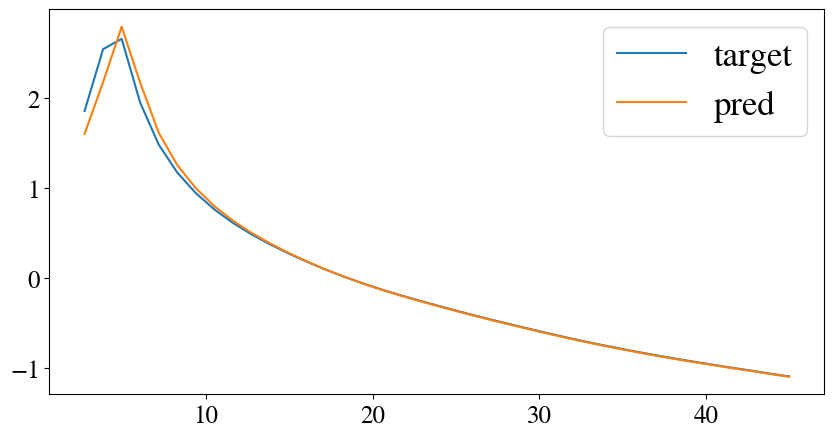

In [149]:
target_psd = PSDs[sub_ix]
pred_psd = _get_psd(result.x)

roi_ix = -1
plt.figure(figsize=(10, 5))
if roi_ix == -1:
    plt.plot(freqs, target_psd.mean(axis=0), label="target")
    plt.plot(freqs, pred_psd.mean(axis=0), label="pred")
else:
    plt.plot(freqs, target_psd[roi_ix], label="target")
    plt.plot(freqs, pred_psd[roi_ix], label="pred")
plt.legend()